In [1]:
#data load
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
#each image is 28x28 pixels
X,y = mnist["data"],mnist["target"]
X.shape,y.shape

((70000, 784), (70000,))

In [3]:
#converting dataframe to np
X = mnist["data"].to_numpy()  # Convert DataFrame to NumPy array
y = mnist["target"].to_numpy()

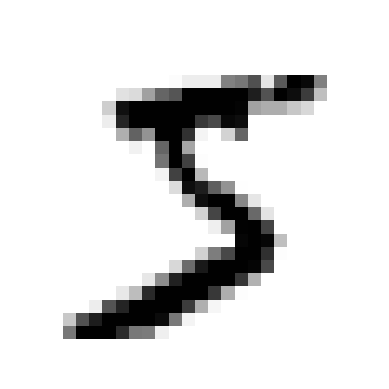

In [4]:
#showing one digit from dataset
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [5]:
#convert labels to integer
import numpy as np
y = y.astype(np.uint8)

In [6]:
#The Dataset is already ordered as train(60k) and test(last 10k) sets
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [7]:
#Training a Binary Classifier for 5
y_train_5 = (y_train ==5)
y_test_5 = (y_test==5)

from sklearn.linear_model import SGDClassifier
#SGDClassifier is efficient for large datasets and  online learning. it's relies on randomness during training
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)


SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict([X[0]])


array([ True])

In [9]:
#Performance Measure:
# 1) cross_val_score: K-fold cv means splitting the training set into K folds , then making preds and evaluating them on each fold using a model trained on the remaining folds
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])

In [10]:
#compare our model with dumb model(not-5)
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

This is why accuracy generally is not the preferred performance measure for classifiers, especially when u r dealing with skewed datasets(when some classes are much more frequent than others) 

In [11]:
#2)Confusion Matrix: Each row repr an actual class, while each col repr a predicted class: 
"""
      N   P 
N  [[TN, FP],
P   [FN, TP]]

"""
# cross_val_predict: performs K-fold cv, but instead of returning the evaluation scores, it returns the predictions made on each test fold
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)


array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

#Precision: accuracy of the positive predictions, TP/(TP+FP)
#Recall: True positive rate (sensitivity), TP/(TP+FN)
#F1-score: harmonic mean of precision and recall. THe regular mean treats all values equally, the harmonic mean gives much more weight to low values.
F1= 2/((1/precision)*(1/recall))

#Precision/Recall Tradeoff.

#decision_function(): returns a score for each instance, and then use any threshold you want to make preds based on the scores.

In [12]:
#Precision & Recall
from sklearn.metrics import precision_score,recall_score,f1_score
print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5,y_train_pred))
print(f1_score(y_train_5,y_train_pred))


0.8370879772350012
0.6511713705958311
0.7325171197343847


# about precision,recall and f1score
1) they are for binary classification problem unless used average='macro' param

2) Macro-average: Takes the average of metrics calculated per class (without considering class imbalance).
Micro-average: Aggregates true positives, false positives, etc., across all classes to calculate global metrics.
Weighted-average: Takes class imbalance into account by weighting the metrics according to the number of samples per class.

In [13]:
#precision/Recall tradeoff:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[2164.22030239]


In [14]:
#SGDClassifier uses threshold = 0
threshold = 0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred 

array([ True])

In [15]:
#increasing threshold decreases recall
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred 

array([False])

In [16]:
#get scores of all instances in the training set, but this time specify that u want to return decision scores instead of preds
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

#orecision_recall_curve(): compute precision & recall for all possible thresholds
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)


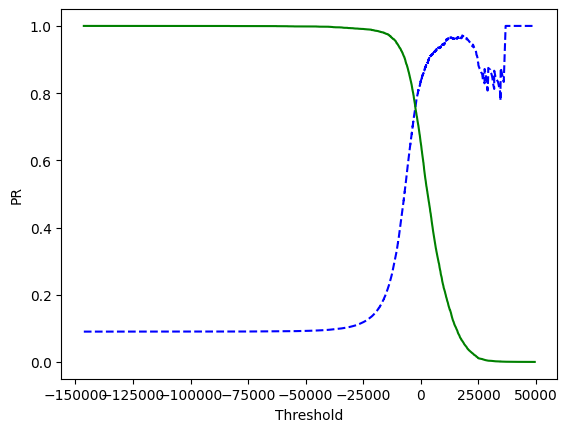

In [17]:
#use matplotlib to plot precision and recall as function of the threshold value
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.ylabel('PR')
    plt.xlabel('Threshold')

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

In [21]:
#create a classifier of 90% precision
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
print(threshold_90_precision)
y_train_pred_90 = (y_scores >= threshold_90_precision)
print('precision',precision_score(y_train_5,y_train_pred_90))
print('recall',recall_score(y_train_5,y_train_pred_90))

3370.0194991439557
precision 0.9000345901072293
recall 0.4799852425751706


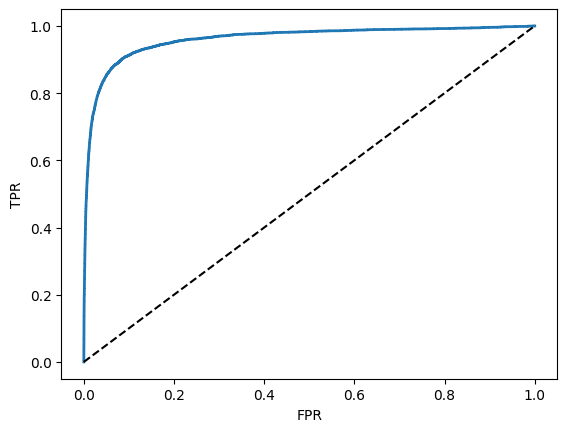

In [22]:
from sklearn .metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

plt.plot(fpr,tpr,linewidth=2,label=None)
plt.plot([0,1],[0,1],'k--') #Dashed Diagonal
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

In [23]:
# ROC AUC = 1 : Perfect classifier
# ROC AUC = 0.5 : purely random classifier
from sklearn.metrics import roc_auc_score as ras
ras(y_train_5,y_scores)

0.9604938554008616

TIP:
As a rule of thumb, you should prefer the PR curve
whenever the positive class is rare or when you care more about the false positives
than the false negatives. Otherwise, use the ROC curve.

In [24]:
#random forest roc & roc auc
#predict_proba(): returns an array containing a row per instance & a col per class, each containing
#the probability that the given instance belongs to the given class.

from sklearn.ensemble import RandomForestClassifier
forest_clf  = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,
                                    X_train,
                                    y_train_5,
                                    cv=3,
                                    method='predict_proba')

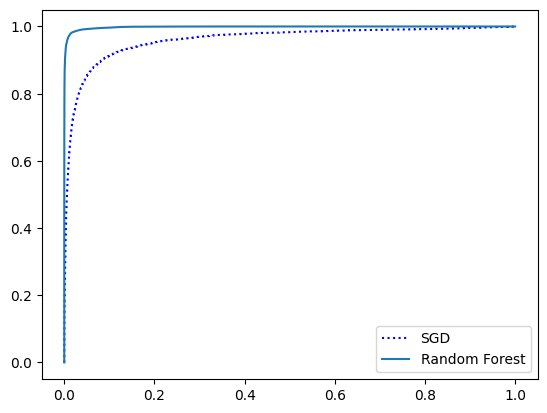

In [ ]:
#roc curve: more to top-left corner the better
y_scores_forest = y_probas_forest[:,1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr,tpr,"b:",label='SGD')
plt.plot(fpr_forest,tpr_forest,label='Random Forest')
plt.legend(loc='lower right')
plt.show()

In [39]:
# ROC AUC Score
print('roc auc',ras(y_train_5,y_scores_forest))
y_pred_forest = (y_scores_forest>=0.50).astype(int)
print('precision',precision_score(y_train_5,y_pred_forest))
print('recall',recall_score(y_train_5,y_pred_forest))

roc auc 0.9983436731328145
precision 0.9897468089558485
recall 0.8725327430363402
